In [18]:
import numpy as np
import matplotlib.pyplot as plt

def simplified_bound(z, L):
    eps = 1e-3
    half_l = (L - 1) * (1 - eps) / 2
    offset = 0.5 if L % 2 == 0 else 0.0
    shift = np.tan(offset / half_l)
    return np.tanh(z + shift) * half_l - offset

def simplified_bound_no_shift(z, L):
    eps = 1e-3
    half_l = (L - 1) * (1 - eps) / 2
    offset = 0.5 if L % 2 == 0 else 0.0
    return np.tanh(z) * half_l - offset

def simplified_bound_no_shift_no_offset(z, L):
    eps = 1e-3
    half_l = (L - 1) * (1 - eps) / 2
    return np.tanh(z) * half_l

def simplified_bound_no_shift_no_offset_no_scale(z, L):
    return np.tanh(z)

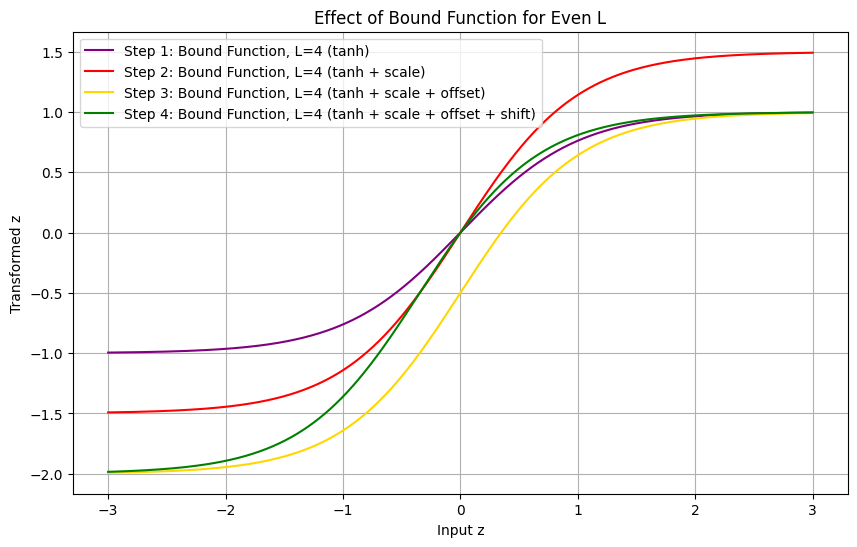

In [20]:
z = np.linspace(-3, 3, 1000)

z_bound_even = simplified_bound(z, 4)
z_bound_even_no_shift = simplified_bound_no_shift(z, 4)
z_bound_even_no_shift_no_offset = simplified_bound_no_shift_no_offset(z, 4)
z_bound_even_no_shift_no_offset_no_scale = simplified_bound_no_shift_no_offset_no_scale(z, 4)

plt.figure(figsize=(10, 6))

plt.plot(z, z_bound_even_no_shift_no_offset_no_scale, label='Step 1: Bound Function, L=4 (tanh)', color='purple')
plt.plot(z, z_bound_even_no_shift_no_offset, label='Step 2: Bound Function, L=4 (tanh + scale)', color='red')
plt.plot(z, z_bound_even_no_shift, label='Step 3: Bound Function, L=4 (tanh + scale + offset)', color='gold')
plt.plot(z, z_bound_even, label='Step 4: Bound Function, L=4 (tanh + scale + offset + shift)', color='green')

# Adding the title, labels, and legend
plt.title('Effect of Bound Function for Even L')
plt.xlabel('Input z')
plt.ylabel('Transformed z')
plt.legend()

# Adding grid for better readability
plt.grid(True)

# Display the combined graph
plt.show()

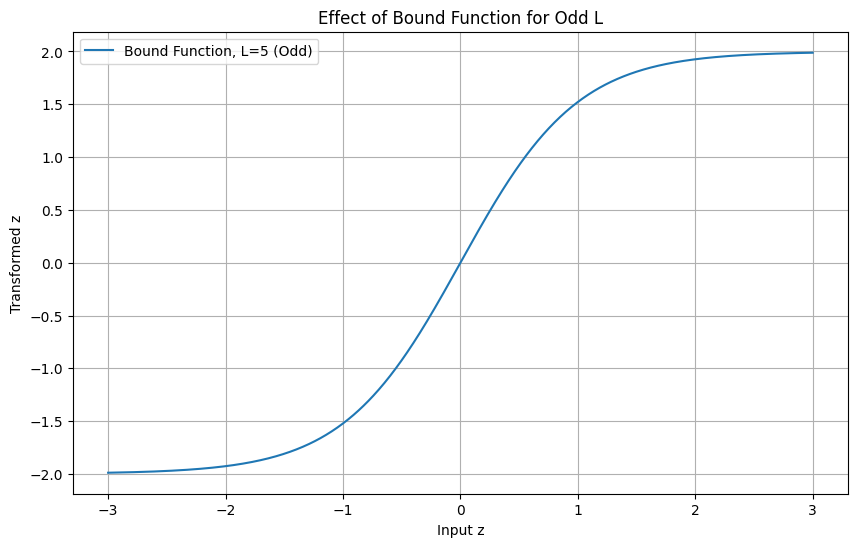

In [ ]:
z_bound_odd = simplified_bound(z, 5)

plt.figure(figsize=(10, 6))
plt.plot(z, z_bound_odd, label='Bound Function, L=5 (Odd)')
plt.title('Effect of Bound Function for Odd L')
plt.xlabel('Input z')
plt.ylabel('Transformed z')
plt.legend()
plt.grid(True)
plt.show()